# Code

In [1]:
import pandas as pd
import os
import time
import numpy as np
import sys
from tqdm.notebook import tqdm
import random
import pickle
from Bio import SeqIO
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.insert(0, '..')
import dataset.preprocessing as utils
from config import *

### Pre-processing

In [2]:
# import data and convert gene_names to ensambl ids

info = utils.read_dataframe(os.path.join(original_files_dir, 'splash', 'annotation_parsed_genesymbol.txt'))
adri_mart =  utils.read_dataframe(os.path.join(original_files_dir, 'annotation_by_biomaRt_hs.txt'))[['ensembl_gene_id', 'external_gene_name']].drop_duplicates('external_gene_name')
info = info.merge(adri_mart, left_on = 'GENESYMBOL', right_on = 'external_gene_name').drop('external_gene_name', axis = 1).rename({'ensembl_gene_id':'gene_id'}, axis = 1)

In [3]:
# adri_mart =  utils.read_dataframe(os.path.join(original_files_dir, 'annotation_by_biomaRt_hs.txt'))[['ensembl_gene_id', 'external_gene_name']].drop_duplicates('external_gene_name')
# mart_export = pd.read_csv(os.path.join(original_files_dir, 'splash', 'mart_export.txt')).drop_duplicates('Gene name')
# mart_export2 = pd.read_csv(os.path.join(original_files_dir, 'splash', 'mart_export_synonyms.txt')).drop_duplicates('Gene name')

# info_adri, other = info[info.GENESYMBOL.isin(set(adri_mart.external_gene_name))], info[~info.GENESYMBOL.isin(set(adri_mart.external_gene_name))]
# assert info.shape[0] == info_adri.shape[0] + other.shape[0]
# info_adri = info_adri.merge(adri_mart, left_on = 'GENESYMBOL', right_on = 'external_gene_name', how = 'left').drop('external_gene_name', axis = 1).rename({'ensembl_gene_id':'gene_id'}, axis = 1)

# info_mart, other2 = other[other.GENESYMBOL.isin(set(mart_export['Gene name']))], other[~other.GENESYMBOL.isin(set(mart_export['Gene name']))]
# assert info.shape[0] == info_adri.shape[0] + info_mart.shape[0] + other2.shape[0]
# info_mart = info_mart.merge(mart_export, left_on = 'GENESYMBOL', right_on = 'Gene name').drop('Gene name', axis = 1).rename({'Gene stable ID':'gene_id'}, axis = 1)

# info_mart2, other3 = other2[other2.GENESYMBOL.isin(set(mart_export2['Gene name']))], other2[~other2.GENESYMBOL.isin(set(mart_export2['Gene name']))]
# assert info.shape[0] == info_adri.shape[0] + info_mart.shape[0] + info_mart2.shape[0] + other3.shape[0]
# info_mart2 = info_mart2.merge(mart_export2, left_on = 'GENESYMBOL', right_on = 'Gene name').drop('Gene name', axis = 1).rename({'Gene stable ID':'gene_id'}, axis = 1)

# info = pd.concat([info_adri, info_mart, info_mart2], axis = 0)

In [4]:
# import data
fasta_file_path = os.path.join(original_files_dir, 'splash', 'our_transcriptome_ncrna-added-dedup.fa')

names = []
cdnas = []

for fasta in SeqIO.parse(open(fasta_file_path), 'fasta'):
    name = str(fasta.description).split(' ')[0]
    cdnas.append(str(fasta.seq))
    names.append(name)

df_cdna = pd.DataFrame({'gene_name':names, 'cdna':cdnas})

df_genes = df_cdna.merge(info, left_on = 'gene_name', right_on = 'GENESYMBOL').drop(['RefSeq', 'GENESYMBOL'], axis = 1)
df_genes = df_genes.rename({'CDS_start':'UTR5', 'CDS_end':'CDS'}, axis = 1)

df_genes['length'] = df_genes.cdna.apply(lambda x: len(x))
df_genes['UTR3'] = df_genes['length']

df_genes['protein_coding'] = True
df_genes.loc[df_genes['UTR5'].isna(), 'UTR3'] = np.nan
df_genes.loc[df_genes['UTR5'].isna(), 'protein_coding'] = False
df_genes['species_set'] = 'human'
df_genes = df_genes[['gene_id', 'gene_name', 'cdna', 'length', 'UTR5', 'CDS', 'UTR3', 'protein_coding', 'species_set']]
df_genes[['UTR3', 'UTR5', 'CDS']] = df_genes[['UTR3', 'UTR5', 'CDS']].apply(pd.to_numeric)
df_genes.to_csv(os.path.join(processed_files_dir, f'df_genes_splash.csv'), index = False)

In [5]:
#import data

filename = os.path.join(original_files_dir, 'splash', 'splash_interactions.bed')

rows = []
with open(filename)as f:
    for line in f:
        L = line.strip().split()
        rows.append(L)
        
all_interactions = pd.DataFrame(rows, columns = ['gene_id1', 'x1', 'x2', 'gene_id2', 'y1', 'y2', 'cell_line', 'boh1', 'boh2', 'boh3'] ).drop(['boh1', 'boh2', 'boh3'], axis = 1)
all_interactions[['x1', 'x2', 'y1', 'y2']] = all_interactions[['x1', 'x2', 'y1', 'y2']].apply(pd.to_numeric)

#change gene name with esnable gene id
original_shape = all_interactions.shape[0]

all_interactions = all_interactions.merge(df_genes[['gene_id', 'gene_name']], left_on = 'gene_id1', right_on = 'gene_name').drop(
    ['gene_id1', 'gene_name'], axis = 1).rename({'gene_id': 'gene_id1'}, axis = 1)

all_interactions = all_interactions.merge(df_genes[['gene_id', 'gene_name']], left_on = 'gene_id2', right_on = 'gene_name').drop(
    ['gene_id2', 'gene_name'], axis = 1).rename({'gene_id': 'gene_id2'}, axis = 1)

new_shape = all_interactions.shape[0]

print(f'We lost {original_shape - new_shape} interactions because of mart merge between gene name and ensamble gene id')

We lost 71 interactions because of mart merge between gene name and ensamble gene id


In [6]:
# swap columns

def swap_genes_if_needed(df):
    original_dim = df.shape[0]
    where = df.need_to_swap
    df.loc[where, ['gene_id1', 'gene_id2']] = (df.loc[where, ['gene_id2', 'gene_id1']].values)
    df.loc[where, ['x1', 'y1']] = (df.loc[where, ['y1', 'x1']].values)
    df.loc[where, ['x2', 'y2']] = (df.loc[where, ['y2', 'x2']].values)
    df = df.drop('need_to_swap', axis = 1)
    df = df.drop_duplicates().reset_index(drop = True)
    n_duplicates = original_dim - df.shape[0] 
    return df

all_interactions[['couples', 'need_to_swap']] = all_interactions[['gene_id1', 'gene_id2']].apply(utils.create_pairs, axis = 1)
all_interactions = swap_genes_if_needed(all_interactions)


# merge cell_line

all_couples = set(all_interactions.couples)

couples = []
cell_lines = []
for couple in all_couples:
    couples.append(couple)
    list_of_cell_lines = list(all_interactions[all_interactions.couples == couple].cell_line.value_counts().index)
    cell_lines.append(','.join(list_of_cell_lines))
df_cell_lines = pd.DataFrame({'couples':couples, 'cell_lines':cell_lines})

df_cell_lines['HeLa'] = df_cell_lines['cell_lines'].str.contains('HeLa').astype(int)
df_cell_lines['ES'] = df_cell_lines['cell_lines'].str.contains('ES').astype(int)
df_cell_lines['RA'] = df_cell_lines['cell_lines'].str.contains('RA').astype(int)
df_cell_lines['LCL'] = df_cell_lines['cell_lines'].str.contains('LCL').astype(int)

all_interactions = df_cell_lines.merge(all_interactions, on = 'couples').drop(['cell_lines', 'cell_line'], axis = 1)
all_interactions['w'] = all_interactions['x2'] - all_interactions['x1']
all_interactions['h'] = all_interactions['y2'] - all_interactions['y1']
all_interactions = all_interactions.drop(['x2', 'y2'], axis = 1)

int_or = all_interactions

# clean bounding boxes 

diz_int = {}
idx = 0

for couple in tqdm(int_or.couples.unique()):
    subset = int_or[int_or.couples == couple]
    list_of_boxes = subset.filter(['x1', 'y1', 'w', 'h']).values.tolist()
    new_list_of_boxes = utils.clean_bounding_boxes(list_of_boxes)
    row = int_or[int_or.couples == couple].iloc[0]
    for box in new_list_of_boxes:
        d = dict(row)
        d['x1'] = box[0]
        d['y1'] = box[1] 
        d['w'] = box[2]
        d['h'] = box[3]
        diz_int[idx] = d
        idx+=1
df_int = pd.DataFrame.from_dict(diz_int, 'index').rename({'gene_id1':'gene1', 'gene_id2':'gene2'}, axis = 1)

print(f'#interazioni prima {int_or.shape[0]}, #interazioni dopo: {df_int.shape[0]}')
print(f'#coppie {len(set(df_int.couples))}')

df_int = df_int[['couples', 'gene1', 'gene2', 'x1', 'y1', 'w', 'h', 'HeLa', 'ES', 'RA', 'LCL']]

  0%|          | 0/1086 [00:00<?, ?it/s]

#interazioni prima 1494, #interazioni dopo: 1316
#coppie 1086


### Drop cds-cds interactions

In [7]:
drop_cds_cds = False

In [8]:
def check_if_cds(x, df_genes):
    df_genes1 = df_genes[df_genes.gene_id == x.gene1].iloc[0]
    if df_genes1.protein_coding:
        cds_interval1 = set(np.arange(df_genes1.UTR5, df_genes1.CDS))
        interval1 = set(np.arange(x.x1, x.x1 + x.w))
        cds1 = len(cds_interval1.intersection(interval1)) > 0
    else:
        cds1 = False
    
    df_genes2 = df_genes[df_genes.gene_id == x.gene2].iloc[0]
    if df_genes2.protein_coding:
        cds_interval2 = set(np.arange(df_genes2.UTR5, df_genes2.CDS))
        interval2 = set(np.arange(x.y1, x.y1 + x.h))
        cds2 = len(cds_interval2.intersection(interval2)) > 0
    else:
        cds2 = False

    return cds1 & cds2

if drop_cds_cds:
    df_int['cds_cds'] = df_int.apply(check_if_cds, args = (df_genes, ), axis = 1)
    df_int = df_int[~df_int.cds_cds]
    assert df_int.cds_cds.all() == False 
    df_int = df_int.drop('cds_cds', axis = 1)

    print(f'#interazioni dopo rimozione cds cds: {df_int.shape[0]}')
    print(f'#coppie dopo rimozione cds cds {len(set(df_int.couples))}')

In [9]:
#add features

df_int = df_int.merge(df_genes[['gene_id', 'length', 'protein_coding']], left_on = 'gene1', right_on = 'gene_id').drop('gene_id', axis = 1).rename({'protein_coding':'protein_coding_1', 'length':'length_1'}, axis = 1)
df_int = df_int.merge(df_genes[['gene_id', 'length', 'protein_coding']], left_on = 'gene2', right_on = 'gene_id').drop('gene_id', axis = 1).rename({'protein_coding':'protein_coding_2', 'length':'length_2'}, axis = 1)
df_int['interacting'] = True

In [10]:
# correct w and h based on the length of the genes (they can exceed and this is wrong)
df_int['exceed1'] = (df_int['x1'] + df_int['w']) - df_int['length_1']
df_int['exceed2'] = (df_int['y1'] + df_int['h']) - df_int['length_2']

df_int['exceed1'] = df_int['exceed1'].clip(lower = 0)
df_int['exceed2'] = df_int['exceed2'].clip(lower = 0)

df_int['w'] = df_int['w'] - df_int['exceed1']
df_int['h'] = df_int['h'] - df_int['exceed2']

df_int = df_int.drop(['exceed1', 'exceed2'], axis = 1)

assert ((df_int.x1 + df_int.w) <= df_int.length_1).all()
assert ((df_int.y1 + df_int.h) <= df_int.length_2).all()

##  Creazione negativi (per linee cellulari) & per regione di interazione

In [12]:
#### Drop all the negative interactions that are seen positive in PARIS or in other experiments

def order_genes(x):
    x1, x2 = x.split('_')
    return utils.get_couple_id(x1, x2)

prohibited_couples = pd.read_csv(os.path.join(original_files_dir, 'prohibited_couples.txt'), sep = '\t')
prohibited_couples['messy_id'] = prohibited_couples['gene_id1'] + '_' + prohibited_couples['gene_id2']
prohibited_couples['id'] = prohibited_couples['messy_id'].apply(order_genes)

prohibited = set(prohibited_couples['id']).union(df_int['couples'])

In [13]:
assert (df_int['couples'].apply(order_genes) == df_int['couples']).all()

In [14]:
def create_interactions_columns(df, df_genes):

    df = df.merge(df_genes, left_on = 'gene1', right_on = 'gene_id')
    df['where_x1'] = 'none'
    df.loc[(df.x1 < df.UTR5), 'where_x1'] = 'UTR5'
    df.loc[(df.x1 >= df.UTR5)&(df.x1 < df.CDS), 'where_x1'] = 'CDS'
    df.loc[(df.x1 >= df.CDS), 'where_x1'] = 'UTR3'
    df = df.drop(['gene_id', 'UTR5', 'CDS', 'UTR3'], axis = 1)
    
    df = df.merge(df_genes, left_on = 'gene2', right_on = 'gene_id')
    df['where_y1'] = 'none'
    df.loc[(df.y1 < df.UTR5), 'where_y1'] = 'UTR5'
    df.loc[(df.y1 >= df.UTR5)&(df.y1 < df.CDS), 'where_y1'] = 'CDS'
    df.loc[(df.y1 >= df.CDS), 'where_y1'] = 'UTR3'
    df = df.drop(['gene_id', 'UTR5', 'CDS', 'UTR3'], axis = 1)
    return df

def where_interacts(x):
    a,b = sorted([x.where_x1, x.where_y1])
    return a + '-' + b

#create train, test, val lists

def train_test_val_split(all_couples, train_frac = 0.7, return_val = True):
    random.seed(23)
    testval_frac = 1 - train_frac
    if return_val:
        val_frac = testval_frac/2

    #Shuffle the list randomly
    random.shuffle(all_couples)

    # Calculate the sizes of each part
    total_count = len(all_couples)
    train_size = int(train_frac * total_count)
    if return_val:
        test_size = int(val_frac * total_count)
        val_size = total_count - train_size - test_size
        
        # Divide the list into three parts
        train_list = all_couples[:train_size]
        test_list = all_couples[train_size:train_size + test_size]
        val_list = all_couples[train_size + test_size:]
        
         # Print the sizes of the three parts
        print("Train List Size:", len(train_list))
        print("Test List Size:", len(test_list))
        print("Validation List Size:", len(val_list))
        assert set(train_list).union(test_list).union(val_list) == set(all_couples)
        assert set(train_list).intersection(test_list).intersection(val_list) == set()
        
        return train_list, test_list, val_list
        
    else:
        train_list = all_couples[:train_size]
        test_list = all_couples[train_size:]
        
        print("Train List Size:", len(train_list))
        print("Test List Size:", len(test_list))
        assert set(train_list).union(test_list) == set(all_couples)
        assert set(train_list).intersection(test_list) == set()
        
        return train_list, test_list
    
def swap_genes_if_needed2(df):
    original_dim = df.shape[0]
    where = df.need_to_swap
    df.loc[where, ['gene1', 'gene2']] = (df.loc[where, ['gene2', 'gene1']].values)
    df.loc[where, ['length_1', 'length_2']] = (df.loc[where, ['length_2', 'length_1']].values)
    df.loc[where, ['where_x1', 'where_y1']] = (df.loc[where, ['where_y1', 'where_x1']].values)
    df.loc[where, ['x1', 'y1']] = (df.loc[where, ['y1', 'x1']].values)
    df.loc[where, ['w', 'h']] = (df.loc[where, ['h', 'w']].values)
    df.loc[where, ['protein_coding_1', 'protein_coding_2']] = (df.loc[where, ['protein_coding_2', 'protein_coding_1']].values)
    df = df.drop('need_to_swap', axis = 1)
    df = df.drop_duplicates().reset_index(drop = True)
    return df

def obtain_negative_subset(df):
    
    assert len(set(df['specie'].value_counts().index)) == 1
    specie = df['specie'].iloc[0]

    assert len(set(df['experiment'].value_counts().index)) == 1
    experiment = df['experiment'].iloc[0]
    
    assert len(set(df['where'].value_counts().index)) == 1
    where = df['where'].iloc[0]
    
    keep_fix = df.filter(['gene1', 'x1', 'w', 'length_1', 'protein_coding_1', 'where_x1'], axis = 1).reset_index(drop = True)
    shuffle = df.filter(['gene2', 'y1', 'h', 'length_2', 'protein_coding_2', 'where_y1'], axis = 1).sample(frac=1, random_state = 23).reset_index(drop = True)
    df_concat = pd.concat([keep_fix, shuffle], axis = 1)

    df_concat[['couples', 'need_to_swap']] = df_concat.rename({'gene1':'gene_id1', 'gene2':'gene_id2'}, axis = 1)[['gene_id1', 'gene_id2']].apply(utils.create_pairs, axis = 1)
    
    df_concat = swap_genes_if_needed2(df_concat)

    df_concat['name'] = np.nan
    df_concat['experiment'] = experiment
    df_concat['specie'] = specie
    df_concat['interacting'] = False
    df_concat['other_id'] = np.nan
    df_concat['simple_repeats'] = np.nan
    df_concat['sine_alu'] = np.nan
    df_concat['low_complex'] = np.nan
    df_concat['n_reads'] = np.nan
    df_concat['is_merged'] = np.nan
    df_concat['where'] = where
    
    return df_concat.reset_index(drop = True)

def create_df_neg(df_int, how_many_negatives_per_positive, experiment_list):

    order_column = list(df_int.columns)

    negs = []

    for _ in tqdm(range(how_many_negatives_per_positive)):
        for exp in experiment_list:
            df_exp = df_int[df_int.experiment == exp].drop_duplicates().reset_index(drop = True)

            #order according to the interaction region
            df_exp['need_to_swap'] = df_exp['where_x1'] + '-' + df_exp['where_y1'] != df_exp['where']
            df_exp = swap_genes_if_needed2(df_exp)
            df_exp['couples'] = df_exp['gene1'] + '_' + df_exp['gene2']
            assert (df_exp['where_x1'] + '-' + df_exp['where_y1'] == df_exp['where']).all()

            for int_region in list(df_exp['where'].value_counts().index):
                subset = df_exp[df_exp['where'] == int_region].reset_index(drop = True)
                subset = obtain_negative_subset(subset)
                subset = subset.filter(order_column, axis = 1)
                negs.append(subset)

    df_neg = pd.concat(negs, axis = 0)
    return df_neg

In [15]:
df_int_old = df_int.copy()
#df_int = df_int_old.copy()

In [16]:
df_int = create_interactions_columns(df_int, df_genes[['gene_id', 'UTR5', 'CDS', 'UTR3']])
df_int['where'] = df_int.apply(where_interacts, axis = 1)
df_int['specie'] = 'human'
all_couples = list(df_int.couples.unique())

In [17]:
train_list, test_list = train_test_val_split(all_couples, return_val = False)
dict_sets = {'train':train_list, 'test':test_list}

Train List Size: 760
Test List Size: 326


In [18]:
how_many_negatives_per_positive = 2

dfs = []
for k in dict_sets.keys():
    int_subset = df_int[df_int.couples.isin(dict_sets[k])].reset_index(drop = True)
    for cell_line in ['HeLa', 'ES', 'RA', 'LCL']:
        df_exp = int_subset[int_subset[cell_line] == 1].drop_duplicates().reset_index(drop = True)
        df_exp['experiment'] = cell_line
        
        df_neg = create_df_neg(df_exp, how_many_negatives_per_positive, [cell_line])
        
        to_drop = set(df_neg['couples']).intersection(prohibited)
    
        df_neg = df_neg[~df_neg['couples'].isin(to_drop)].reset_index(drop = True)

        dict_sets[k] = list(set(df_neg['couples']).union(dict_sets[k]))

        df_set = pd.concat([df_exp, df_neg], axis = 0).reset_index(drop = True)
        dfs.append(df_set)

df = pd.concat(dfs, axis = 0).reset_index(drop = True)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [19]:
### In the negative set, I want to keep only 1 negative for each positive, otherwise valentino classes has problems.
df_int, df_neg = df[df.interacting], df[df.interacting == False]

df_neg = df_neg.drop_duplicates('couples')

### In the positive set, the problem was related to the experiment column, now I approach in another way with respect to paris, I need to drop duplicates
df_int = df_int.drop_duplicates(['couples', 'x1', 'y1', 'w', 'h'])

df = pd.concat([df_int, df_neg], axis = 0).drop_duplicates().reset_index(drop = True)

In [20]:
def plot_interaction_region(df):
    df_int, df_neg = df[df.interacting == True], df[df.interacting == False]
    
    # PLOT 
    categories = list(set(df_int['where'].value_counts().index).union(df_neg['where'].value_counts().index))

    neg = df_neg['where'].value_counts()
    neg = pd.Series([neg.get(key, 0) for key in categories], index=categories)

    pos = df_int['where'].value_counts()
    pos = pd.Series([pos.get(key, 0) for key in categories], index=categories)

    values1 = pos.values

    values2 = neg.values

    total1 = sum(values1)
    total2 = sum(values2)

    percentages1 = np.array([value / total1 * 100 for value in values1])
    percentages2 = np.array([value / total2 * 100 for value in values2])

    bar_width = 0.35
    index = np.arange(len(categories))

    fig, ax = plt.subplots(figsize=(12, 8))
    bar1 = ax.bar(index, percentages1, bar_width, label='Positive Distribution', color='skyblue')
    bar2 = ax.bar(index + bar_width, percentages2, bar_width, label='Negative Distribution', color='orange')

    ax.set_xlabel('Categories')
    ax.set_ylabel('Percentage')
    ax.set_title('Comparison of Two Distributions')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(categories, rotation=45, ha='right')
    ax.legend()

    plt.tight_layout()
    plt.show()

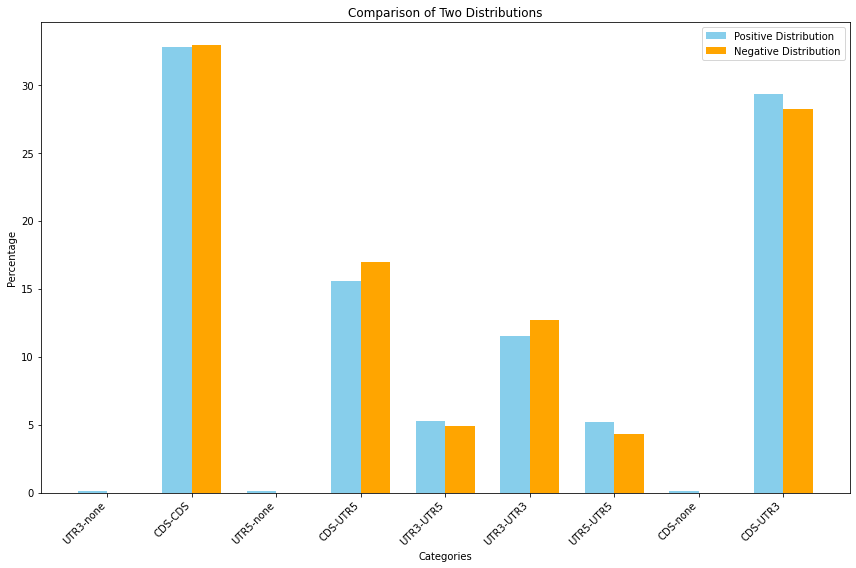

In [21]:
plot_interaction_region(df[df.couples.isin(dict_sets['train'])])

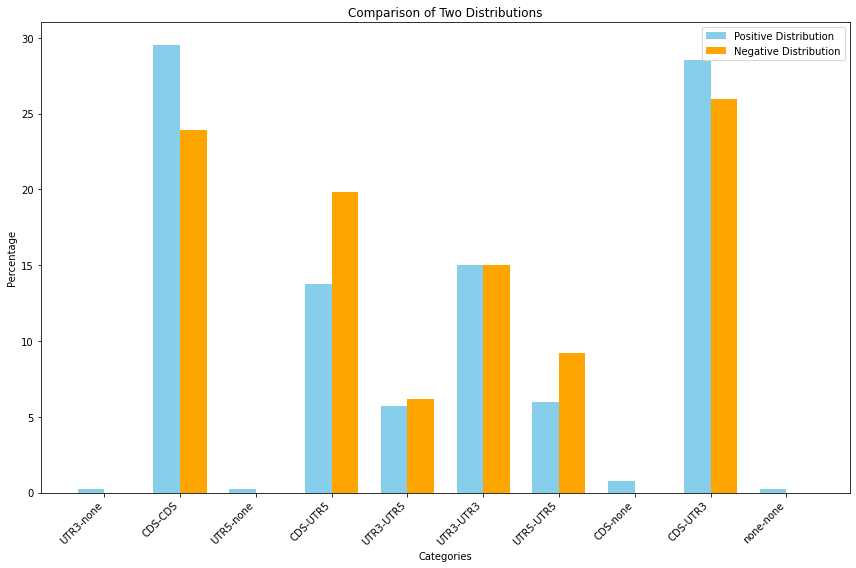

In [22]:
plot_interaction_region(df[df.couples.isin(dict_sets['test'])])

In [23]:
df[df.interacting == True].shape[0]

1316

In [24]:
df[df.interacting == False].shape[0]

944

In [27]:
# Export
df.to_csv(os.path.join(processed_files_dir, f'splash.csv'), index = False)

file_name_training, file_name_test = ['gene_pairs_training.txt', 'gene_pairs_test.txt']
save_path = os.path.join(rna_rna_files_dir, f'splash')
if os.path.isdir(save_path) == False:
    os.mkdir(save_path)
        
file_training = os.path.join(save_path, file_name_training)
file_test = os.path.join(save_path, file_name_test)    

with open(file_training, "wb") as fp:   #Pickling
    pickle.dump(dict_sets['train'], fp)

with open(file_test, "wb") as fp:   #Pickling
    pickle.dump(dict_sets['test'], fp)

##  Creazione negativi (per linee cellulari) (MODO VECCHIO)

In [11]:
# #colleziono tutti i positivi, quelli che non potranno mai essere visti nel set dei negativi

# def order_genes(x):
#     x1, x2 = x.split('_')
#     return utils.get_couple_id(x1, x2)

# prohibited_couples = pd.read_csv(os.path.join(original_files_dir, 'prohibited_couples.txt'), sep = '\t')
# prohibited_couples['messy_id'] = prohibited_couples['gene_id1'] + '_' + prohibited_couples['gene_id2']
# prohibited_couples['id'] = prohibited_couples['messy_id'].apply(order_genes)
# prohibited_interactions = set(prohibited_couples['id']).union(set(all_interactions.couples.apply(order_genes)))

In [36]:
# #creazione negativi (per linee cellulari)

# how_many_negatives_per_positive = 2 

# df_pairs_full = []
# for cell_line in ['HeLa', 'ES', 'RA', 'LCL']:
#     df_exp = df_int[df_int[cell_line] == 1][['gene1', 'gene2']].drop_duplicates().reset_index(drop = True)
#     df_exp['positive'] = df_exp['gene1'] + '_' + df_exp['gene2']
#     for i in range(how_many_negatives_per_positive):
#         df_exp['gene2'] = df_exp.sample(frac=1, replace=False, random_state=42).reset_index(drop = True)['gene2']
#         df_exp[f'negative{i}'] = df_exp['gene1'] + '_' + df_exp['gene2']
#     df_exp['cell_line'] = cell_line
#     df_pairs_full.append(df_exp[['positive', 'negative0', 'negative1', 'cell_line']])
# df_pairs_full = pd.concat(df_pairs_full, axis = 0)
# assert set(df_pairs_full.positive) == set(df_int['gene1'] + '_' + df_int['gene2'])

# df_pairs_full = pd.concat([
#     df_pairs_full[['positive', 'negative0', 'cell_line']].rename({'negative0':'negative'}, axis = 1),
#     df_pairs_full[['positive', 'negative1', 'cell_line']].rename({'negative1':'negative'}, axis = 1)
# ], axis = 0)

# df_pairs_full['negative'] = df_pairs_full['negative'].apply(order_genes)
# df_pairs_full['positive'] = df_pairs_full['positive'].apply(order_genes)

# assert set(df_pairs_full.positive) == set((df_int['gene1'] + '_' + df_int['gene2']).apply(order_genes))

# to_drop = set(df_pairs_full['negative']).intersection(prohibited_interactions)

# print('how many to drop', len(to_drop))

# df_pairs_full = df_pairs_full[~df_pairs_full['negative'].isin(to_drop)]

# print(f'We have {len(set(df_pairs_full.positive))} pairs interacting (they can have multiple interactions) \n')
# print(f'We have {len(set(df_pairs_full.negative))} pairs not interacting \n')

# df_pairs_full.to_csv(os.path.join(processed_files_dir, 'df_pairs_full_RANDOM_SPLASH.csv'), index = False)

In [34]:
##### Create fake negative interactions

In [12]:
# df_pairs_full = pd.read_csv(os.path.join(processed_files_dir, 'df_pairs_full_RANDOM_SPLASH.csv'))
# df_int1 = df_int[['gene1', 'x1', 'w']].rename({'gene1':'gene', 'x1':'c1',  'w': 'l'}, axis = 1)
# df_int2 = df_int[['gene2', 'y1', 'h']].rename({'gene2':'gene', 'y1':'c1',  'h': 'l'}, axis = 1)
# df_int = df_int[['couples', 'gene1', 'gene2', 
#              'interacting', 'length_1', 'length_2',
#              'protein_coding_1', 'protein_coding_2',
#              'x1', 'y1', 'w', 'h']]
    
# df_coord = pd.concat([df_int1, df_int2], ignore_index = True)#.drop_duplicates().reset_index(drop = True)
# #df_coord may have duplicates. but this is something I want. If a gene appears more than once, I want it to be sampled according to its distribution.

In [35]:
# df_neg = df_pairs_full[['negative']].drop_duplicates().reset_index(drop = True)
# df_neg[['gene1', 'gene2']] = df_neg['negative'].str.split('_', expand = True)
# df_neg = df_neg.rename({'negative':'couples'}, axis = 1)
# df_neg['interacting'] = False
# df_neg = df_neg.merge(df_genes[['gene_id', 'length', 'protein_coding']], left_on = 'gene1', right_on = 'gene_id').drop('gene_id', axis = 1).rename({'length': 'length_1','protein_coding':'protein_coding_1'} , axis = 1)
# df_neg = df_neg.merge(df_genes[['gene_id', 'length', 'protein_coding']], left_on = 'gene2', right_on = 'gene_id').drop('gene_id', axis = 1).rename({'length': 'length_2','protein_coding':'protein_coding_2'} , axis = 1)

# assert set(df_neg.gene1).union(set(df_neg.gene2)) - set(df_coord.gene) == set()
# df_coord = df_coord.merge(
#     df_genes.filter(['gene_id', 'UTR5', 'CDS', 'UTR3', 'protein_coding'], axis = 1).rename({'gene_id':'gene'}, axis = 1)
# )
# df_coord['where_c1'] = df_coord.apply(utils.where_interacts, axis = 1)

# start_time = time.time()
# new_cols = df_neg[['couples', 'gene1', 'gene2']].apply(utils.create_fake_coord_neg, axis = 1, args = (df_coord,df_pairs_full,df_int,))
# print(f"Total time: {(time.time()-start_time)/60} minutes")

# new_cols = new_cols.apply(pd.Series).rename({0:'x1', 1:'y1', 2:'w', 3:'h'}, axis = 1)
# df_neg = pd.concat([df_neg, new_cols], axis = 1)
# df = pd.concat([df_int, df_neg], ignore_index = True, axis = 0)

# df.to_csv(os.path.join(processed_files_dir, f'final_splash_RANDOM.csv'), index = False)

### Now I do checks

In [29]:
df = pd.read_csv(os.path.join(processed_files_dir, f'splash.csv'))
df_neg, df_int = df[df.interacting == False], df[df.interacting == True]

df_int1 = df_int[['gene1', 'x1', 'w']].rename({'gene1':'gene', 'x1':'c1',  'w': 'l'}, axis = 1)
df_int2 = df_int[['gene2', 'y1', 'h']].rename({'gene2':'gene', 'y1':'c1',  'h': 'l'}, axis = 1)
df_coord = pd.concat([df_int1, df_int2], ignore_index = True)#.drop_duplicates().reset_index(drop = True)


# mario: 0. min
# ricseq: min
#check if it worked
start_time = time.time()
for _, row in tqdm(df_neg.iterrows(), total = df_neg.shape[0]):
    g1 = row.gene1
    g2 = row.gene2
    assert [row.x1, row.w] in df_coord[df_coord.gene == g1][['c1', 'l']].values
    assert [row.y1, row.h] in df_coord[df_coord.gene == g2][['c1', 'l']].values
    if np.random.rand() < 0.0003: #progress
        print(f"{np.round(_/df_neg.shape[0] * 100, 2)}% in {(time.time()-start_time)/60} minutes")
print(f"Total time: {(time.time()-start_time)/60} minutes")

  0%|          | 0/944 [00:00<?, ?it/s]

Total time: 0.028201703230539957 minutes


In [30]:
#check if it worked
assert (df.x1 <= df.length_1).all()
assert (df.y1 <= df.length_2).all()

In [31]:
assert ((df_int.x1 + df_int.w) <= df_int.length_1).all()
assert ((df_int.y1 + df_int.h) <= df_int.length_2).all()

assert ((df_neg.x1 + df_neg.w) <= df_neg.length_1).all()
assert ((df_neg.y1 + df_neg.h) <= df_neg.length_2).all()


In [32]:
df_neg = df[df.interacting == False]

In [33]:
#check if it worked
assert (df_neg.x1 <= df_neg.length_1).all()
assert ((df_neg.x1 + df_neg.w) <= df_neg.length_1).all()
assert (df_neg.y1 <= df_neg.length_2).all()
assert ((df_neg.y1 + df_neg.h) <= df_neg.length_2).all()

# mario: 0. min
# ricseq: min
#check if it worked
start_time = time.time()
for _, row in tqdm(df_neg.iterrows(), total = df_neg.shape[0]):
    g1 = row.gene1
    g2 = row.gene2
    assert [row.x1, row.w] in df_coord[df_coord.gene == g1][['c1', 'l']].values
    assert [row.y1, row.h] in df_coord[df_coord.gene == g2][['c1', 'l']].values
    if np.random.rand() < 0.0003: #progress
        print(f"{np.round(_/df_neg.shape[0] * 100, 2)}% in {(time.time()-start_time)/60} minutes")
print(f"Total time: {(time.time()-start_time)/60} minutes")

  0%|          | 0/944 [00:00<?, ?it/s]

Total time: 0.029511996110280356 minutes


# Plots 

### Interaction Length distribution

In [34]:
df = pd.read_csv(os.path.join(processed_files_dir, f'splash.csv'))

median = 102.0 nucleotides


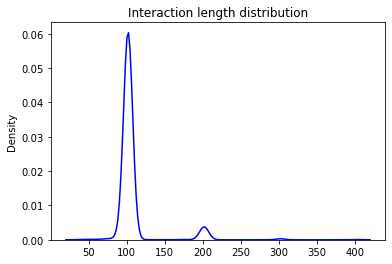

In [35]:
df_int = df[df.interacting]
lengths = list(pd.concat([df_int.w, df_int.h]))
print(f'median = {np.median(lengths)} nucleotides')
sns.kdeplot(lengths, color = 'blue')
plt.title(f'Interaction length distribution')
plt.show()

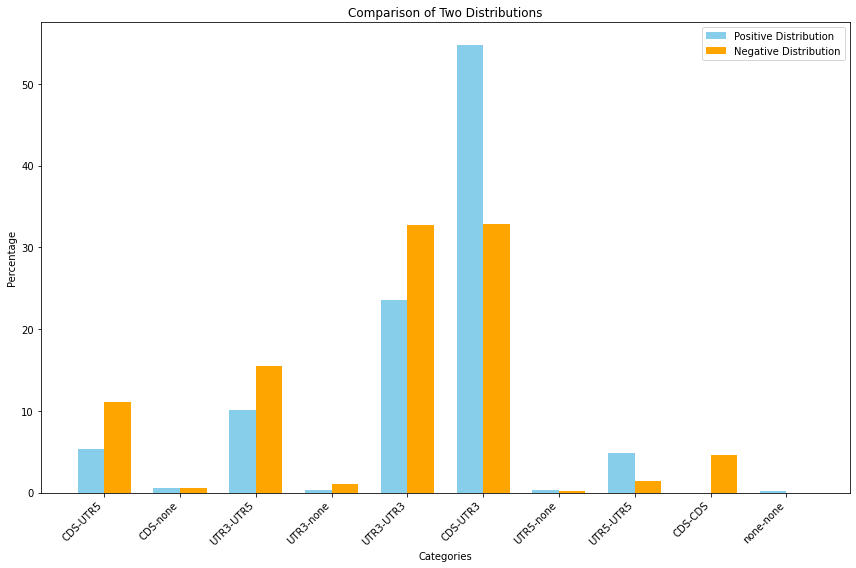

In [25]:
# OLD WITHOUT CDS-CDS
plot_interaction_region(df)

# Create train-test (OLD)

In [27]:
# from dataset.train_test_val_utils import train_test_split_from_df_pairs
# import pickle

# PERC_TRAIN = 0.75

# splash_dir = '/data01/giorgio/RNARNA-NT/dataset/rna_rna_pairs/SPLASH'

# if not os.path.exists(splash_dir):
#     os.makedirs(splash_dir)

# file_training = os.path.join(splash_dir, 'training.txt')
# file_test = os.path.join(splash_dir, 'test.txt')

In [28]:
# df_pairs_full = pd.read_csv(os.path.join(processed_files_dir, 'df_pairs_full_RANDOM_SPLASH.csv'))

# df_pairs_full['gene1'] = df_pairs_full.positive.str.split('_', expand = True)[0]
# df_pairs_full['gene2'] = df_pairs_full.positive.str.split('_', expand = True)[1]

# df_pairs_full['gene1_neg'] = df_pairs_full.negative.str.split('_', expand = True)[0]
# df_pairs_full['gene2_neg'] = df_pairs_full.negative.str.split('_', expand = True)[1]

In [29]:
# all_pairs = set(df_pairs_full.positive).union(df_pairs_full.negative)

# gp_training, gp_test = train_test_split_from_df_pairs(df_pairs_full, percentage_training = PERC_TRAIN)
# train_couples = set(df_pairs_full[df_pairs_full.positive.isin(gp_training)].negative).union(gp_training)
# test_couples = set(df_pairs_full[df_pairs_full.positive.isin(gp_test)].negative).union(gp_test)


# train_couples = train_couples
# common_pairs = train_couples.intersection(test_couples)
# test_couples = test_couples - common_pairs
# assert set(test_couples).union(train_couples) == all_pairs

# with open(file_training, "wb") as fp:   #Pickling
#     pickle.dump(list(train_couples), fp)

# with open(file_test, "wb") as fp:   #Pickling
#     pickle.dump(list(test_couples), fp)